In [0]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Divide train and test set

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

N_FACE = 70
N_POSE = 25
N_HAND = 21
FOLDER = '/content/drive/My Drive/636/data/json/'
CSV_FOLDER = '/content/drive/My Drive/636/dataset/'

In [0]:
dataset = pd.read_csv(CSV_FOLDER + 'dataset_pose_only.csv')

In [0]:
vid = dataset.vid.unique()

from sklearn.model_selection import train_test_split
X_train_vid, X_test_vid= train_test_split(vid, test_size=0.15, random_state=9)
print(X_train_vid.shape, X_test_vid.shape)

X_test_data = dataset.loc[dataset['vid'].isin(X_test_vid)]
X_test_data = X_test_data.reset_index()
X_test_data.drop(X_test_data.columns[[0]], axis=1, inplace=True)

X_train_data = dataset.loc[dataset['vid'].isin(X_train_vid)]
X_train_data = X_train_data.reset_index()
X_train_data.drop(X_train_data.columns[[0]], axis=1, inplace=True)

print(X_test_data.shape[0] / dataset.shape[0])
print(X_test_data.index[X_test_data['label'] == 1].shape[0] / X_test_data.index[X_test_data['label'] == 0].shape[0])

(443,) (79,)
0.15321356121618504
0.976339705421498


In [0]:
print(X_train_data.shape, X_test_data.shape)

(69710, 53) (12613, 53)


In [0]:
# X_train_data.vid.unique()

In [0]:
# get number of features
# N_FEATURES = (N_FACE + N_POSE + N_HAND * 2) * 2
N_FEATURES = N_POSE * 2

In [0]:
N_FEATURES

50

# slice every TIME_STEP frame as a segment and shuffle

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[3:]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
y_train = X_train_data['label'].to_numpy()
y_test = X_test_data['label'].to_numpy()

In [0]:
X_train = create_segments(X_train_data, 15)
X_test = create_segments(X_test_data, 15)

In [0]:
# shuffle data
idx_train = np.random.permutation(y_train.shape[0])
X_train, y_train = X_train[idx_train], y_train[idx_train]

In [0]:
X_train.shape

(69710, 15, 50)

# draw plot

In [0]:
# draw
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'b', label='Training acc', color='red')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss', color='red')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

# Build model

In [0]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Activation, Dropout, Flatten, Bidirectional, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import History, EarlyStopping, ModelCheckpoint

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# hyperparameter
TIME_STEP = 15
BATCH_SIZE = 64
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = N_FEATURES
# callbacks
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
# callbacks_list = [early_stop, mcp_save]
callbacks_list = [early_stop]
model_path = './drive/My Drive/636/model/'

## Model 1 3 LSTM

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=30, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 15, 64)            3264      
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 15, 64)            33280     
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 15, 32)            12544     
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 32)            0         
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

## Model 2 CNN Batch_size = 64

In [0]:
def create_model_1(X_train):
  model = Sequential()

  model.add(Conv1D(32, 3, padding ='same', input_shape=(X_train.shape[1:])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  model.add(BatchNormalization())
  
  model.add(Conv1D(64, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(64, 3, padding ='same'))
  model.add(BatchNormalization())
  
  model.add(Conv1D(64, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(64, 3, padding ='same'))
  model.add(BatchNormalization())

  model.add(GlobalAveragePooling1D())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
# create model
model_1 = create_model_1(X_train)
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 15, 32)            4832      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 32)            128       
_________________________________________________________________
activation_1 (Activation)    (None, 15, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 32)            128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 64)            6208      
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 64)           

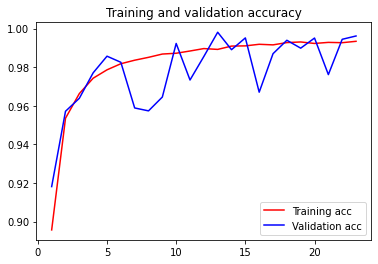

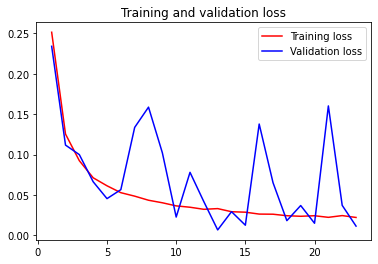

In [0]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_7984.csv')

## Model 2 CNN batch_size = 32

In [0]:
# create model
model_1 = create_model_1(X_train)
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=32, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 15, 32)            4832      
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 32)            128       
_________________________________________________________________
activation_4 (Activation)    (None, 15, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 32)            128       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 15, 64)            6208      
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 64)           

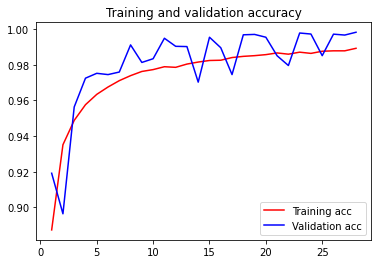

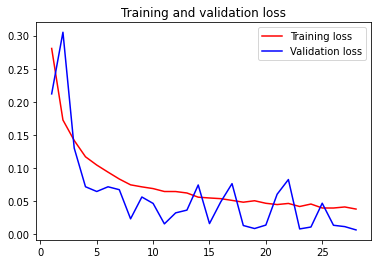

In [0]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_8372.csv')

## Model 2 CNN val_split = 0.15

In [0]:
# create model
model_1 = create_model_1(X_train)
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 15, 32)            4832      
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 32)            128       
_________________________________________________________________
activation_7 (Activation)    (None, 15, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 32)            128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 15, 64)            6208      
_________________________________________________________________
batch_normalization_15 (Batc (None, 15, 64)           

In [0]:
model_1.save(model_path + 'model1_8286.csv')

## Model 2 CNN time_step = 20

In [0]:
X_train_20 = create_segments(X_train_data, 20)
X_test_20 = create_segments(X_test_data, 20)
# shuffle data
# idx_train = np.random.permutation(y_train.shape[0])
# X_train_20, y_train = X_train_20[idx_train], y_train[idx_train]

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 20, 32)            4832      
_________________________________________________________________
batch_normalization_25 (Batc (None, 20, 32)            128       
_________________________________________________________________
activation_13 (Activation)   (None, 20, 32)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 20, 32)            3104      
_________________________________________________________________
batch_normalization_26 (Batc (None, 20, 32)            128       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 20, 64)            6208      
_________________________________________________________________
batch_normalization_27 (Batc (None, 20, 64)           

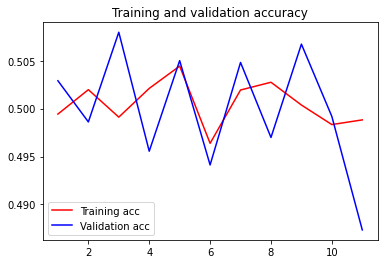

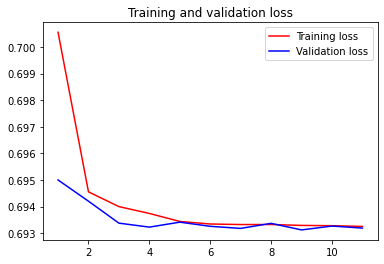

In [0]:
# create model
model_1_20 = create_model_1(X_train_20)
history = model_1_20.fit(X_train_20, y_train, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1_20.evaluate(X_test_20, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_1_20.save(model_path + 'model1_20_8569.csv')